In [1]:
# Use these commands in the same cell.
%load_ext autoreload
%autoreload 2
from base_model_backtest import backtest

In [3]:
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
base = datetime.datetime.today()
date_list = [base + datetime.timedelta(days=x) for x in range(len(df))]
df.index = date_list
prices = np.array([df.ewc,df.ewa]).T


In [ ]:
delta = 0.0001
ve = 0.001


In [2]:
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from multiprocessing import Process
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import random
from mathCode.johansenMain import coint_johansen
from tqdm import tqdm_notebook
from IPython.display import clear_output
import itertools
import datetime
import os
from base_model_backtest import backtest
import random
from pandas_datareader import data as pdr
import logging
from pandas.plotting import register_matplotlib_converters
from functionSource import *

register_matplotlib_converters()
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
plt.style.use(['ggplot'])


from models.Cointegrated_Pairs_1 import cointegrated_pairs_1


        
global toTrade
global price
global df
global results
global runDate

#Ranges for parameters
# ve_values =  [round(0.1**(ve_), 11) for ve_ in range(2,10)]
# delta_values = [round(0.1**(delta_), 11) for delta_ in range(2,10)]
ve_values = [1e-09]
delta_values = [1e-05]

transactionFeesPercent = 0
minimumComission = 0
capitalPerTrade = 1

toTrade = ['GOLD.AX','OOO.AX']
riskFreeTs = '^AXJO'


data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
close = data.xs('CLOSE', axis = 1, level = 1)
close = close[toTrade].dropna()


#Create rundate and directory of logs and results
runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalman_' + flatten(toTrade) +'_'+ runDate 
try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')



def runThatShitBack(delta, cointegrated_pairs_1):

    for ve in ve_values:

    
        #Update to include specific deltas and ve
        logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)
        try:
            os.makedirs(logDirectoryBatch)
        except Exception as e:
            pass

        strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

        #Run the
        strategy.run()


        #Print simmary of results
        results.info([delta, ve, np.cumsum(strategy.returns.values)[-1], strategy.numberOfTrades])

       #Re-index the returns, placing zero on days where no trades were made
        dates = strategy.dfHistory.index
        returns =  strategy.returns.T.reindex(dates, fill_value=0)
        plt.plot(returns)
        plt.show()
        #Calculate Drawdowns
        drawdownArray, drawDownDf = drawdowns(returns.returns)
            
        #Calculate Alpha, beta, sharpe values
        alpha, beta = alpha_beta(returns, riskFreeTs)
        sharpeRatio = sharpe(returns, riskFreeTs)
        APRvalue = APR(returns)
        #Print simmary of results
        results.info([delta, ve, np.cumsum(strategy.returns.values)[-1], strategy.numberOfTrades])

        print(len(returns), len(dates))

        plotResults(dates,
                    returns,
                    np.cumsum(returns),
                    riskFreeTs,
                    directory = logDirectoryBatch,
                    drawdownArray = drawdownArray,
                    maxDrawDown = round(min(drawdownArray),4),
                    maxDrawDownDuration = drawDownLength(drawDownDf),
                    alpha = round(alpha,4),
                    beta = round(beta,4),
                    sharpe = round(sharpeRatio,4),
                    APR = round(APRvalue,4),
                    additionalData = [['ve',str(ve)],
                                        ['delta',str(delta)],
                                        ['comission',str(transactionFeesPercent)],
                                        ['minComish',str(minimumComission)],
                                        ['capPerTr',str(capitalPerTrade)],
                                        ['numTrades',str(strategy.numberOfTrades)]])




        # except Exception as e:
        #     print(e)



if __name__ == '__main__':

    processes = []
    for delta in delta_values:
        process = Process(target=runThatShitBack, args=(delta, cointegrated_pairs_1))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()


    


In [3]:
df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')


In [35]:
toTrade = ['ewa','ewc']
close = df[toTrade]



ve = 0.001
delta = 0.0001

transactionFeesPercent = 0.0008
minimumComission = 0
capitalPerTrade = 1

logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)

runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalmanEWAEWC_' + flatten(toTrade) +'_'+ runDate 

try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

try:
    os.makedirs(logDirectoryBatch)
except Exception as e:
    pass

        
results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')

strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

strategy.run()

In [34]:
data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
close = data.xs('CLOSE', axis = 1, level = 1)
close = close[toTrade].dropna()

toTrade = ['GOLD.AX','OOO.AX']


ve = 1e-09
delta = 1e-05

transactionFeesPercent = 0
minimumComission = 0
capitalPerTrade = 1

logDirectoryBatch = logDirectory +  '/delta_'+str(delta) + '_ve_'+str(ve)

runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/MULTI_pairTradeKalman_' + flatten(toTrade) +'_'+ runDate 

try:
    os.makedirs(logDirectory)
except Exception as e:
    pass

try:
    os.makedirs(logDirectoryBatch)
except Exception as e:
    pass

        
results = setup_logger('results', logDirectory+'/results.log')
results.info('Delta, Ve, Final Returns Value, Number of Trades')

KeyError: "None of [Index(['ewa', 'ewc'], dtype='object')] are in the [columns]"

In [17]:
close[toTrade]

,GOLD.AX,OOO.AX
Date,,
2011-11-16,169.86,54.81
2011-11-17,168.68,56.90
2011-11-18,167.01,54.60
2011-11-22,165.80,53.55
2011-11-23,169.39,53.70
2011-11-24,168.50,53.00
2011-11-25,169.12,53.28
2011-11-30,166.54,55.20
2011-12-06,163.41,55.75


In [15]:
strategy = cointegrated_pairs_1(close[toTrade],
                            toTrade, 
                            3, 
                            False, 
                            False, 
                            decimalPlaces = None,
                            lookback = None, 
                            delta = delta,
                            ve = ve,
                            riskFreeTs = riskFreeTs,
                            logDir = logDirectoryBatch,
                            transactionFeesPercent = transactionFeesPercent,
                            minimumComission = minimumComission,
                            InitialCapital = 0,
                            capitalPerTrade = capitalPerTrade)

strategy.run()

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


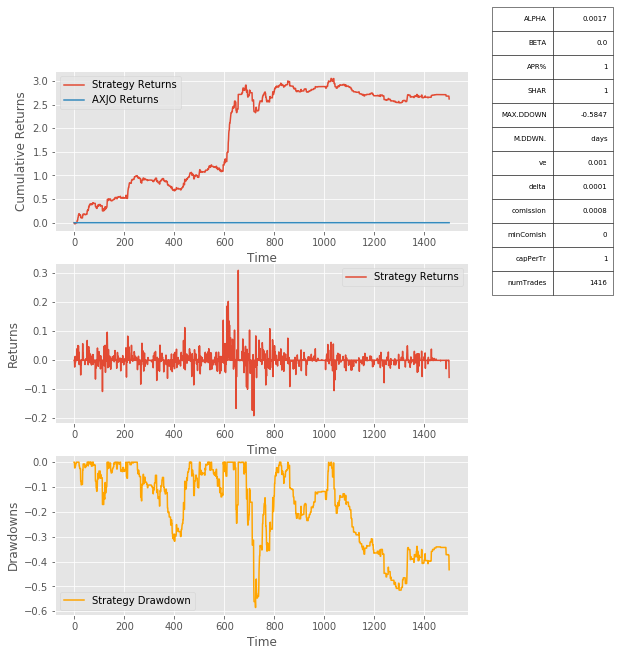

In [36]:
dates = strategy.dfHistory.Date
returns =  strategy.returns.T.reindex(dates, fill_value=0)

#Calculate Drawdowns
drawdownArray, drawDownDf = drawdowns(returns.returns)

#Calculate Alpha, beta, sharpe values
alpha, beta = alpha_beta(returns, riskFreeTs)
# sharpeRatio = sharpe(returns, riskFreeTs)
sharpeRatio = 1
# APRvalue = APR(returns)
APRvalue =1
plotResults(dates,
                    returns,
                    np.cumsum(returns),
                    riskFreeTs,
                    directory = logDirectoryBatch,
                    drawdownArray = drawdownArray,
                    maxDrawDown = round(min(drawdownArray),4),
                    maxDrawDownDuration = drawDownLength(drawDownDf),
                    alpha = round(alpha,4),
                    beta = round(beta,4),
                    sharpe = round(sharpeRatio,4),
                    APR = round(APRvalue,4),
                    additionalData = [['ve',str(ve)],
                                        ['delta',str(delta)],
                                        ['comission',str(transactionFeesPercent)],
                                        ['minComish',str(minimumComission)],
                                        ['capPerTr',str(capitalPerTrade)],
                                        ['numTrades',str(strategy.numberOfTrades)]])

In [23]:
strategy.dfHistory.head()

,Date,GOLD.AX,OOO.AX
0,2011-11-16,169.86,54.81
0,2011-11-17,168.68,56.90
0,2011-11-18,167.01,54.60
0,2011-11-22,165.80,53.55
0,2011-11-23,169.39,53.70


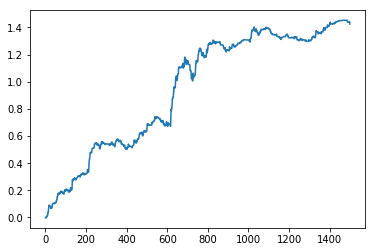

In [27]:
plt.plot(np.cumsum(o.returns))

In [32]:

import bs4 as bs
from bs4 import BeautifulSoup

import urllib.request
import requests
rows = []
for index, row in enumerate(soup.find('table').findAll('tr')):
    if index == 0:
        rowTemp = row.text.split('\n')
        colNames = [x for x in rowTemp if x != '']
    else:
        rowTemp = row.text.split('\n')
        rowTemp = [x for x in rowTemp if x != '']
        rows.append(rowTemp)
etfs = pd.DataFrame(rows)
etfs.columns = colNames
codes = []
for index, etf in etfs.iterrows():
    code = etf['ASX Code'] + '.AX'
    codes.append(code)

for code in codes:
    url = 'https://finance.yahoo.com/quote/ETF.AX/history?p='+code
    headers = {'User-Agent':'Mozilla/5.0'}
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    print(soup.find('tbody'))
    break
import fix_yahoo_finance as fyf
from pandas_datareader import data as pdr
price = pdr.get_data_yahoo(codes[:40], start = '2015-01-01')

NameError: name 'soup' is not defined

In [26]:
from pandas_datareader import data as pdr


In [8]:
df = price.Close.dropna()
toTrade = ['LNG.AX','STO.AX']
values = []
for delta_ in range(1,7):
    for ve_ in range (1,7):
        try:
            delta = 0.1**delta_
            ve = 0.1**ve_
            o = cointegrated_pairs_1(df[toTrade], toTrade, 3, False, False, 
                    decimalPlaces = None,
                    lookback = None, 
                    delta = delta,
                    ve = ve,
                    capitalPerTrade = 1)
            temp = [delta, ve, np.cumsum(o.returns)[-1]]
            print(temp)
            values.append(temp)
        except Exception as e:
            print(e)

name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'cointegrated_pairs_1' is not defined
name 'coint

In [7]:
toTrade = ['GOLD.AX','OSH.AX']

price = pdr.get_data_yahoo(toTrade, start = '2010-01-01')

In [155]:
#Maximum [1.0000000000000003e-05, 0.0010000000000000002, 3.533554237991313]
def flatten(list_):
    string = ''
    for element in list_:
        string = string + element.replace('.','')+'_'

    return string

# toTrade = ['GOLD.AX','OSH.AX']
# price = pdr.get_data_yahoo(toTrade, start = '2010-01-01')
# df = price.Close.dropna()
toTrade = ['ewa','ewc']
        
values = []
# for delta_ in range(1,7):
#     for ve_ in range (1,7):
try:
#     delta = 0.0001 + 0.1**(4+delta_)
#     ve = 0.0001 + 0.1**(4+ve_)
    delta = 0.0001 
    ve = 0.001
    runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-7]
    logDirectory = 'pairTradeKalman_' + flatten(toTrade) +'_'+ runDate + '_delta_'+str(delta) + '_ve_'+str(ve)
    logDirectory = 'C:/Users/Billy/Documents/PRISMO/logs/'+ logDirectory
    os.mkdir(logDirectory)

    strategy = cointegrated_pairs_1(df[toTrade], toTrade, 3, False, False, 
                        decimalPlaces = None,
                        lookback = None, 
                        delta = delta,
                        ve = ve,
                        capitalPerTrade = 300,
                        logDir = logDirectory)

    temp = [delta, ve, np.cumsum(strategy.returns)[-1]]
    print(temp)
    values.append(temp)

except Exception as e:
    print(e)
 


[1e-06, 1e-09, 1.4569634328817151]


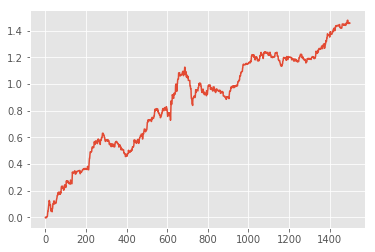

In [157]:
plt.plot(np.cumsum(strategy.returns))

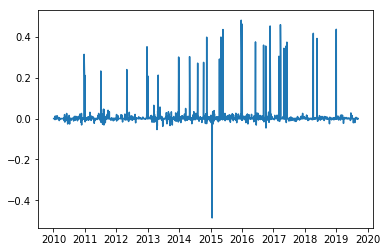

In [20]:
plt.plot(strategy.dfHistory.Date, strategy.returns)
plt.show()

Text(0.5, 1.0, 'Cumulative Returns')

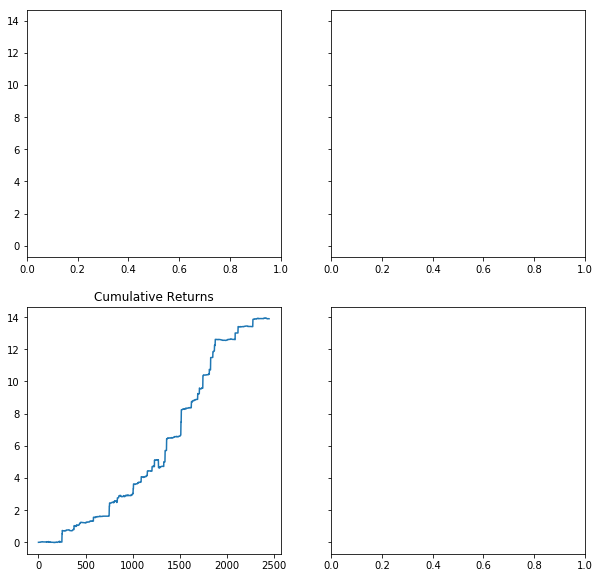

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
            # axs[0,0].plot(strategy.dfHistory)
            # axs[0,0].set_title('Original Series(s)')

axs[1,0].plot(np.cumsum(strategy.returns))
axs[1,0].set_title('Cumulative Returns')

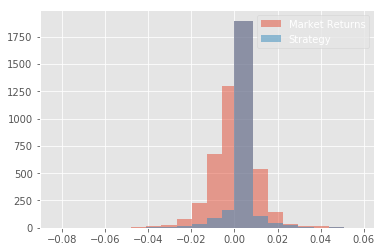

In [145]:
plt.style.use(['ggplot'])
n, bins, patches = plt.hist(marketReturns, 20, alpha = 0.5 )

binsWithZero =sorted(bins.tolist()+[0])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)+1])

plt.clf()

#Gotta include 0, delete the proceeding element

plt.hist(marketReturns, binsWithZero, alpha = 0.5 )
plt.hist(strategy.returns, binsWithZero, alpha = 0.5)
plt.legend(['Market Returns','Strategy'])

plt.show()

In [152]:
marketReturns[strategy.dfHistory.Date]

Date
2010-01-03    0.001170
2010-01-04    0.009844
2010-01-05   -0.000589
2010-01-06   -0.004470
2010-01-07    0.002592
2010-01-10    0.007858
2010-01-11   -0.010342
2010-01-12   -0.006409
2010-01-13    0.006142
2010-01-14    0.000327
2010-01-17    0.002347
2010-01-18   -0.010161
2010-01-19    0.001440
2010-01-20   -0.008422
2010-01-21   -0.015868
2010-01-24   -0.006883
2010-01-26   -0.015537
2010-01-27    0.006179
2010-01-28   -0.022190
2010-01-31   -0.009957
2010-02-01    0.017948
2010-02-02    0.009250
2010-02-03   -0.005658
2010-02-04   -0.023260
2010-02-07    0.001617
2010-02-08   -0.003605
2010-02-09    0.001842
2010-02-10    0.009062
2010-02-11    0.001713
2010-02-14   -0.003639
                ...   
2019-07-29    0.004769
2019-07-30    0.002828
2019-07-31   -0.004748
2019-08-01   -0.003479
2019-08-02   -0.002990
2019-08-05   -0.018955
2019-08-06   -0.024427
2019-08-07    0.006391
2019-08-08    0.007455
2019-08-09    0.002482
2019-08-12    0.000896
2019-08-13   -0.003308
2019-0

In [153]:
np.cumsum(marketReturns)

Date
2000-01-04   -0.024243
2000-01-05   -0.030669
2000-01-06   -0.022634
2000-01-09   -0.002591
2000-01-10    0.022312
2000-01-11   -0.000593
2000-01-12   -0.003669
2000-01-13    0.008185
2000-01-16    0.010143
2000-01-17    0.012226
2000-01-18   -0.002960
2000-01-19    0.007428
2000-01-20   -0.005134
2000-01-23   -0.006338
2000-01-24   -0.013179
2000-01-26   -0.012293
2000-01-27   -0.007967
2000-01-30   -0.002877
2000-01-31   -0.005442
2000-02-01    0.006927
2000-02-02    0.017247
2000-02-03    0.009705
2000-02-06    0.015541
2000-02-07    0.014808
2000-02-08    0.019689
2000-02-09    0.033150
2000-02-10    0.025318
2000-02-13    0.011079
2000-02-14    0.020720
2000-02-15    0.020117
                ...   
2019-07-29    1.023481
2019-07-30    1.026308
2019-07-31    1.021560
2019-08-01    1.018081
2019-08-02    1.015091
2019-08-05    0.996136
2019-08-06    0.971710
2019-08-07    0.978100
2019-08-08    0.985555
2019-08-09    0.988036
2019-08-12    0.988933
2019-08-13    0.985625
2019-0

In [141]:
binsWithZero =sorted(bins.tolist()+[0])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)+1])
binsWithZero.remove(binsWithZero[binsWithZero.index(0)-1])

In [142]:
binsWithZero

[-0.0833622530752205,
 -0.0762993373641241,
 -0.06923642165302771,
 -0.06217350594193131,
 -0.05511059023083491,
 -0.048047674519738515,
 -0.04098475880864212,
 -0.03392184309754572,
 -0.02685892738644933,
 -0.01979601167535293,
 -0.012733095964256536,
 0,
 0.008455651169032644,
 0.01551856688012905,
 0.022581482591225444,
 0.029644398302321837,
 0.03670731401341823,
 0.04377022972451464,
 0.050833145435611016,
 0.05789606114670742]

In [123]:
sorted(bins.tolist()+[0])

[-0.0833622530752205,
 -0.07663566668370012,
 -0.06990908029217974,
 -0.06318249390065936,
 -0.05645590750913899,
 -0.04972932111761861,
 -0.04300273472609824,
 -0.03627614833457786,
 -0.02954956194305748,
 -0.022822975551537103,
 -0.016096389160016725,
 -0.009369802768496346,
 -0.002643216376975982,
 0,
 0.004083370014544396,
 0.010809956406064775,
 0.017536542797585153,
 0.02426312918910553,
 0.03098971558062591,
 0.03771630197214629,
 0.044442888363666666,
 0.051169474755187044,
 0.05789606114670742]

In [89]:
marketReturns = df.pct_change() 
marketReturns = marketReturns[np.abs(marketReturns-marketReturns.mean()) <= 1]

In [76]:
marketReturns[np.abs(marketReturns-marketReturns.mean()) >1]

Series([], Name: Adj Close, dtype: float64)

(array([   6.,   13.,   53.,  178.,  607., 1021.,  430.,  103.,   25.,
           3.]),
 array([-0.04090444, -0.03316189, -0.02541934, -0.01767679, -0.00993424,
        -0.00219169,  0.00555085,  0.0132934 ,  0.02103595,  0.0287785 ,
         0.03652105]),
 <a list of 10 Patch objects>)

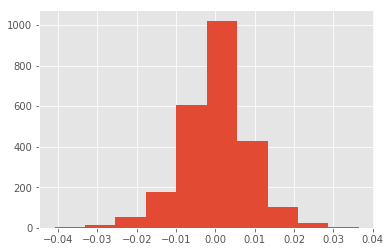

In [77]:
plt.hist(marketReturns)

In [86]:

price = pdr.get_data_yahoo('^AXJO', start = '2000-01-01', interval = 'd')
df = price['Adj Close']

ValueError: ('Unknown string format:', 'max')

In [84]:
df

Date
2000-01-03     3093.699951
2000-01-04     3018.699951
2000-01-05     2999.300049
2000-01-06     3023.399902
2000-01-09     3084.000000
2000-01-10     3160.800049
2000-01-11     3088.399902
2000-01-12     3078.899902
2000-01-13     3115.399902
2000-01-16     3121.500000
2000-01-17     3128.000000
2000-01-18     3080.500000
2000-01-19     3112.500000
2000-01-20     3073.399902
2000-01-23     3069.699951
2000-01-24     3048.699951
2000-01-26     3051.399902
2000-01-27     3064.600098
2000-01-30     3080.199951
2000-01-31     3072.300049
2000-02-01     3110.300049
2000-02-02     3142.399902
2000-02-03     3118.699951
2000-02-06     3136.899902
2000-02-07     3134.600098
2000-02-08     3149.899902
2000-02-09     3192.300049
2000-02-10     3167.300049
2000-02-13     3122.199951
2000-02-14     3152.300049
                  ...     
2019-08-01     6788.899902
2019-08-02     6768.600098
2019-08-05     6640.299805
2019-08-06     6478.100098
2019-08-07     6519.500000
2019-08-08     6568.100

In [87]:
df[strategy.dfHistory.Date]

Date
2010-01-03     4876.299805
2010-01-04     4924.299805
2010-01-05     4921.399902
2010-01-06     4899.399902
2010-01-07     4912.100098
2010-01-10     4950.700195
2010-01-11     4899.500000
2010-01-12     4868.100098
2010-01-13     4898.000000
2010-01-14     4899.600098
2010-01-17     4911.100098
2010-01-18     4861.200195
2010-01-19     4868.200195
2010-01-20     4827.200195
2010-01-21     4750.600098
2010-01-24     4717.899902
2010-01-26     4644.600098
2010-01-27     4673.299805
2010-01-28     4569.600098
2010-01-31     4524.100098
2010-02-01     4605.299805
2010-02-02     4647.899902
2010-02-03     4621.600098
2010-02-04     4514.100098
2010-02-07     4521.399902
2010-02-08     4505.100098
2010-02-09     4513.399902
2010-02-10     4554.299805
2010-02-11     4562.100098
2010-02-14     4545.500000
                  ...     
2019-07-29     6825.799805
2019-07-30     6845.100098
2019-07-31     6812.600098
2019-08-01     6788.899902
2019-08-02     6768.600098
2019-08-05     6640.299

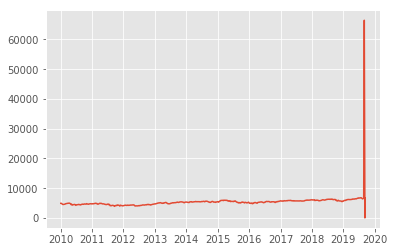

In [49]:
plt.plot(df)

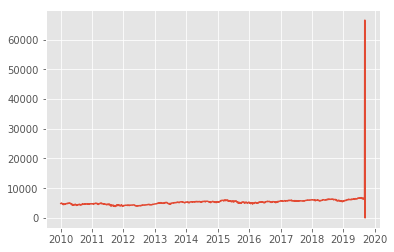

In [36]:
plt.plot(df)

In [62]:
max([x[2] for x in values])

3.533554237991313

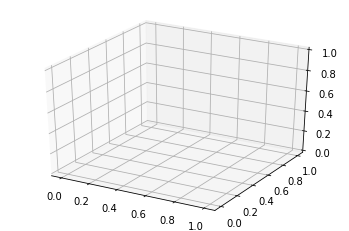

In [44]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = [x[0] for x in values],ys = [x[1] for x in values],zs = [x[2] for x in values] )

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


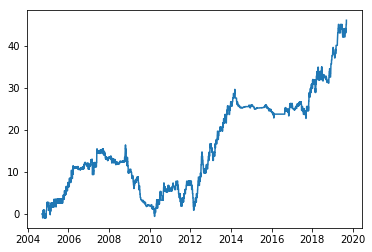

In [57]:
plt.plot(df.index, np.cumsum(o.returns))

In [73]:
import os
os.mkdir('C:/Users/Billy/Documents/PRISMO/logs/yo')

In [92]:
runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-7]

In [112]:
def flatten(list_):
    string = ''
    for element in list_:
        string = string + element.replace('.','')+'_'
    return string

directory = 'pairTradeKalman_' + flatten(toTrade) +'_'+ runDate

In [113]:
print(directory)

pairTradeKalman_LNGAX_STOAX__2019_09_08_16_36_33


In [103]:
print(flatten(toTrade))

LNG.AX
STO.AX
LNGAX_STOAX_


In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs[0,0].plot(x, y)
axs[0,0].set_title('yo')
axs[1,0].plot(x, y)
axs[0,1].plot(x, y)

fig.savefig('C:/Users/Billy/Documents/PRISMO/results/pic.jpg')   # save the figure to file
plt.close(fig)    # close the figure

In [21]:
strategy.pnl

NameError: name 'strategy' is not defined

In [31]:
for line in open('C:/Users/Billy/Documents/PRISMO/results/cointegrated_pairs_1_2019_09_09_14_06_16.log', 'r'):
    print(line)

2019-09-09 14:06:56,418 INFO [0.1, 0.1, 0]

2019-09-09 14:06:57,475 INFO [0.01, 0.1, 0]

2019-09-09 14:07:04,071 INFO [0.001, 0.1, 0.5937150482054959]

2019-09-09 14:07:10,078 INFO [0.0001, 0.1, 10.551216456244072]

2019-09-09 14:07:10,914 INFO [1e-05, 0.1, 12.376083662933038]

2019-09-09 14:07:18,245 INFO [1e-09, 0.1, 12.938888795772204]

2019-09-09 14:07:19,205 INFO [1e-06, 0.1, 15.134275995396727]

2019-09-09 14:07:29,260 INFO [1e-08, 0.1, 15.606148696242698]

2019-09-09 14:07:32,737 INFO [1e-07, 0.1, 17.19891416143309]

2019-09-09 14:08:04,335 INFO [0.1, 0.01, 0]

2019-09-09 14:08:04,335 INFO [0.1, 0.01, 0]

2019-09-09 14:08:06,057 INFO [0.01, 0.01, 0]

2019-09-09 14:08:06,057 INFO [0.01, 0.01, 0]

2019-09-09 14:08:20,435 INFO [0.001, 0.01, 0.5937242092245394]

2019-09-09 14:08:20,435 INFO [0.001, 0.01, 0.5937242092245394]

2019-09-09 14:08:30,866 INFO [0.0001, 0.01, 10.552339285388966]

2019-09-09 14:08:30,866 INFO [0.0001, 0.01, 10.552339285388966]

2019-09-09 14:08:37,614 INFO [


2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:35,160 INFO [0.1, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:43,540 INFO [0.01, 1e-07, 0]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:22:52,927 INFO [1e-08, 0.0001, 23.93601346480192]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937252482102255]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937252482102255]

2019-09-09 14:23:42,839 INFO [0.001, 1e-07, 0.5937


2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:35:21,327 INFO [1e-05, 1e-09, 11.219894732274748]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:09,851 INFO [1e-07, 1e-05, 17.996037966141223]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 INFO [1e-09, 1e-06, 23.149083501446235]

2019-09-09 14:37:23,062 

In [40]:
df = pickle.load(open('D:/Crypto_data/ohlc_data/poloniex/1d/BTC-USDT_data.pickle','rb'))
df2 = pickle.load(open('D:/Crypto_data/ohlc_data/poloniex/1d/ETH-USDT_data.pickle','rb'))

In [42]:
df2.Close

Date
2015-08-08 09:30:00      1.400000
2015-08-09 09:30:00      1.400000
2015-08-10 09:30:00      1.400000
2015-08-11 09:30:00      1.100000
2015-08-12 09:30:00      1.380000
2015-08-13 09:30:00      2.140000
2015-08-14 09:30:00      2.150000
2015-08-15 09:30:00      1.500000
2015-08-16 09:30:00      1.120000
2015-08-17 09:30:00      1.520000
2015-08-18 09:30:00      1.010000
2015-08-19 09:30:00      1.300000
2015-08-20 09:30:00      1.730000
2015-08-21 09:30:00      1.500000
2015-08-22 09:30:00      1.330001
2015-08-23 09:30:00      1.500000
2015-08-24 09:30:00      1.300000
2015-08-25 09:30:00      1.050000
2015-08-26 09:30:00      1.000000
2015-08-27 09:30:00      1.270000
2015-08-28 09:30:00      1.060000
2015-08-29 09:30:00      1.060000
2015-08-30 09:30:00      1.270000
2015-08-31 09:30:00      1.300000
2015-09-01 09:30:00      1.250001
2015-09-02 09:30:00      1.260001
2015-09-03 09:30:00      1.370000
2015-09-04 09:30:00      1.219400
2015-09-05 09:30:00      1.373368
2015-09-0

In [45]:
df = pd.concat([df.Close,df2.Close], axis=1)

In [48]:
df.columns = ['BTC','ETH']

In [49]:
df

,BTC,ETH
Date,,
2015-02-19 10:30:00,244.000000,NaN
2015-02-20 10:30:00,240.250000,NaN
2015-02-21 10:30:00,245.000000,NaN
2015-02-22 10:30:00,235.000000,NaN
2015-02-23 10:30:00,235.000000,NaN
2015-02-24 10:30:00,239.750000,NaN
2015-02-25 10:30:00,237.750000,NaN
2015-02-26 10:30:00,238.500000,NaN
2015-02-27 10:30:00,249.000000,NaN


In [396]:
toTrade = ['BBOZ.AX','ETPMAG.AX']
riskFreeTs = '^AXJO'
data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
close = data.xs('CLOSE', axis = 1, level = 1)
close_ = close[toTrade].dropna()
close = close_
# df = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
# df.set_index('Date',inplace=True)
# toTrade = ['ewa','ewc']
# close = df[toTrade]
# ve_values = [x/10000000 for x in range(0,10000000,1000)]
# delta_values = [0.0001]
ve_values = []
delta_values = []
for ve_ in range(1,10):
    order = round(0.1**(ve_), 11)
    for i in range(1,10):
        ve_values.append(round(i*order,11))
        delta_values.append(round(i*order,11))


In [437]:
def monotonicityMeasure(returns):
     # Start by counting how many points in the future returns are greater than the current
     # If its less than current, we want to emphasise that it's non monatonic in the long run and is a bad strategy
    # Check x chunks for monotonicity
    chunks = 50
    binWidth = int(len(returns)/chunks)
    
    totalCounter = 0
    monotonicCounter = 0
    for i in range(0,len(returns),binWidth):
        for j in range(i+chunks,len(returns),binWidth):
            
            if returns[j]>returns[i]:
                monotonicCounter +=1
            
            totalCounter+=1
            
    return monotonicCounter/totalCounter
    

In [439]:
results=[]
# for delta in tqdm_notebook(delta_values):
#     for Ve in tqdm_notebook(ve_values):
        
for delta in [0.0002]:
    for Ve in [0.002]:
        close = close_
        #INIT
        yhatList = []
        QList= []
        eList=[]
        betaList = [np.matrix([[0],[0]])]
        R = np.zeros([len(toTrade),len(toTrade)])
        P = np.zeros([len(toTrade),len(toTrade)])
        y = []
        hedges = []
        Vw = delta/(1-delta)*np.diag(np.ones(len(toTrade)))

        for row in close.iterrows():
            #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
            x = np.matrix([[row[1][toTrade[0]]],[1]])
            y = np.matrix(row[1][toTrade[1]])

            ## 1 STEP AHEAD PREDICTION ##
            beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
            R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
            yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
            e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
            Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
            #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
            #                                                                             = x . R(t|t-1) + Ve


            ## UPDATE PARAMETERS ##
            K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
            beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
            P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

            #Add beta and predicted y values to arrays for storage
            betaList.append(beta)
            yhatList.append(yhat)

            #Form the hedge ratio as a float
            hedgeRatio = beta[0].tolist()[0][0]
            hedges.append(hedgeRatio)
            eList.append(e_t.tolist()[0][0])
            QList.append(Q_t.tolist()[0][0])

        close['e'] = eList
        close["Q"] = QList
        
        if np.mean(close['e'])>np.mean(close['Q']):
            print(np.mean(close['e']), np.mean(close['Q']))
#             if the average error is greater than the average error, the parameters are fucked. No point going further

            break
    
    
    
        close['LongEntry'] = close['e']<-np.sqrt(close['Q'])
        close['LongExit'] = close['e']>-np.sqrt(close['Q'])
        close['ShortEntry'] = close['e']>np.sqrt(close['Q'])
        close['ShortExit'] = close['e']<np.sqrt(close['Q'])
        ratios = hedges
        numUnitsLong = np.array([[np.nan]]*len(close))
        numUnitsShort = np.array([[np.nan]]*len(close))

        numUnitsLong[0] = 1
        numUnitsLong[np.array(close['LongEntry'])] = 1
        numUnitsLong[np.array(close['LongExit'])] = 0

        numUnitsShort[0] = 1
        numUnitsShort[np.array(close['ShortEntry'])] = -1
        numUnitsShort[np.array(close['ShortExit'])] = 0

        close['short'] = numUnitsShort
        close['short'].fillna('ffill')
        close['long'] =  numUnitsLong
        close['long'].fillna('ffill')

        close['numUnits'] = close['long'] + close['short']

        close['numUnits'+toTrade[0]] = -close['numUnits']*ratios
        close['numUnits'+toTrade[1]] = close['numUnits']

        close['positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
        close['positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]

        close['pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))

        close['returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

        sharpe = (np.mean(close['returns']))
        try:
            numTrades = len(close[close['numUnits']!=0])/2
            if numTrades > 50:
                monotonicity = monotonicityMeasure(np.cumsum(close['returns'].fillna(0)))
                weightedSharpe = monotonicity*sharpe
                weightedRet = monotonicity*np.cumsum(close['returns'].fillna(0)).iloc[-1]
            
                results.append([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])
        except Exception as e:
            print(e)

1
2
3
4


In [466]:
res = optimize(['BBOZ.AX','ETPMAG.AX','ETF'])

1e-06 1e-06
means 0.03382011720380982 0.0003934564798497042
Date
2015-04-20         NaN
2015-04-21   -0.003973
2015-04-22    0.011221
2015-04-23   -0.001302
2015-04-24    0.015265
2015-04-27   -0.009047
2015-04-28   -0.004884
2015-04-29    0.025521
2015-04-30   -0.012029
2015-05-01   -0.000256
2015-05-04         NaN
2015-05-05    0.003804
2015-05-06   -0.026079
2015-05-07   -0.015469
2015-05-08    0.003255
2015-05-11    0.004143
2015-05-12    0.007086
2015-05-13   -0.016090
2015-05-14   -0.003132
2015-05-15   -0.013792
2015-05-18   -0.006367
2015-05-19    0.002523
2015-05-20   -0.019007
2015-05-21    0.012949
2015-05-22    0.004398
2015-05-25    0.017191
2015-05-26   -0.009954
2015-05-27    0.015866
2015-05-29    0.024968
2015-06-01    0.016890
                ...   
2019-08-28   -0.033118
2019-08-29   -0.010160
2019-08-30   -0.016805
2019-09-02    0.005466
2019-09-03    0.008773
2019-09-04   -0.030211
2019-09-05   -0.005775
2019-09-06    0.027154
2019-09-09   -0.020406
2019-09-10   -0

Name: returns, Length: 1130, dtype: float64
2e-06 1e-07
means 0.03369678758387628 0.0007831239536964311
Date
2015-04-20         NaN
2015-04-21   -0.003980
2015-04-22    0.011221
2015-04-23   -0.001302
2015-04-24    0.015265
2015-04-27   -0.009047
2015-04-28   -0.004884
2015-04-29    0.025521
2015-04-30   -0.012029
2015-05-01   -0.000256
2015-05-04         NaN
2015-05-05    0.003804
2015-05-06   -0.026079
2015-05-07   -0.015470
2015-05-08    0.003255
2015-05-11    0.004143
2015-05-12    0.007086
2015-05-13   -0.016089
2015-05-14   -0.003132
2015-05-15   -0.013792
2015-05-18   -0.006366
2015-05-19    0.002523
2015-05-20   -0.019007
2015-05-21    0.012949
2015-05-22    0.004398
2015-05-25    0.017191
2015-05-26   -0.009954
2015-05-27    0.015866
2015-05-29    0.024968
2015-06-01    0.016890
                ...   
2019-08-28   -0.033193
2019-08-29   -0.010178
2019-08-30   -0.016803
2019-09-02    0.005471
2019-09-03    0.008801
2019-09-04   -0.030298
2019-09-05   -0.005758
2019-09-06    0.0

Name: returns, Length: 1130, dtype: float64
2e-07 1e-06
means 0.034330669146597055 8.027313897071109e-05
Date
2015-04-20         NaN
2015-04-21   -0.003946
2015-04-22    0.011222
2015-04-23   -0.001301
2015-04-24    0.015265
2015-04-27   -0.009047
2015-04-28   -0.004885
2015-04-29    0.025521
2015-04-30   -0.012029
2015-05-01   -0.000256
2015-05-04    0.015084
2015-05-05    0.003805
2015-05-06   -0.026079
2015-05-07   -0.015469
2015-05-08    0.003254
2015-05-11    0.004143
2015-05-12    0.007086
2015-05-13   -0.016090
2015-05-14   -0.003134
2015-05-15   -0.013793
2015-05-18   -0.006369
2015-05-19    0.002523
2015-05-20   -0.019006
2015-05-21    0.012949
2015-05-22    0.004399
2015-05-25    0.017191
2015-05-26   -0.009953
2015-05-27    0.015867
2015-05-29    0.024966
2015-06-01    0.016892
                ...   
2019-08-28   -0.032825
2019-08-29   -0.010086
2019-08-30   -0.016810
2019-09-02    0.005446
2019-09-03    0.008663
2019-09-04   -0.029867
2019-09-05   -0.005841
2019-09-06    0.

In [456]:
res

[['delta', 've', 'cumret', 'sharpe', 'weightedCum', 'weightedSharpe'],
 [1e-06,
  1e-06,
  0.1777135370866835,
  0.00016500792672858225,
  0.14941875431915663,
  0.000138736076433757],
 [1e-06,
  2e-06,
  0.15738749107799258,
  0.00014572915840554965,
  0.13072419847183853,
  0.00012104092451096241],
 [1e-06,
  1e-07,
  0.17773502743610803,
  0.00016502788062776973,
  0.14943682306784928,
  0.00013875285335919149],
 [1e-06,
  2e-07,
  0.17773275636177246,
  0.0001650257719236515,
  0.14943491358417263,
  0.0001387510803938466],
 [2e-06,
  1e-06,
  0.16483948370709398,
  0.00015595031571153634,
  0.13937016740097827,
  0.00013185446300944013],
 [2e-06,
  2e-06,
  0.16756700286606604,
  0.00015868087392619933,
  0.14180768320979237,
  0.0001342875787971522],
 [2e-06,
  1e-07,
  0.16482838488018725,
  0.00015593981540225872,
  0.13936078345164066,
  0.0001318455851008901],
 [2e-06,
  2e-07,
  0.16482966417335454,
  0.00015594102570799857,
  0.13936186508147153,
  0.0001318466084025274],
 

In [465]:
def optimize(toTrade):
    asset = toTrade[-1]
    toTrade = toTrade[:-1]

    if asset == 'ETF':
        data = pickle.load(open( "D:/PRISMO/historicalData/ETFSnobiasFINAL.pickle", "rb" ) )
        close = data.xs('CLOSE', axis = 1, level = 1)
        close_= close[toTrade].dropna()

    results=[]
    results.append(['delta','ve','cumret','sharpe','weightedCum','weightedSharpe'])
    ve_values = []
    delta_values = []
    for ve_ in range(1,3):
        order = round(0.1**(ve_+5), 8)
        for i in range(1,3):
            ve_values.append(round(i*order,8))
            delta_values.append(round(i*order,8))

        
    for delta in delta_values:
        for Ve in ve_values:
            print(delta, Ve)
            close = close_
            #INIT
            yhatList = []
            QList= []
            eList=[]
            betaList = [np.matrix([[0],[0]])]
            R = np.zeros([len(toTrade),len(toTrade)])
            P = np.zeros([len(toTrade),len(toTrade)])
            y = []
            hedges = []
            Vw = delta/(1-delta)*np.diag(np.ones(len(toTrade)))

            for row in close.iterrows():
                #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
                x = np.matrix([[row[1][toTrade[0]]],[1]])
                y = np.matrix(row[1][toTrade[1]])

                ## 1 STEP AHEAD PREDICTION ##
                beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
                R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
                yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
                e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
                Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
                #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
                #                                                                             = x . R(t|t-1) + Ve


                ## UPDATE PARAMETERS ##
                K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
                beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
                P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

                #Add beta and predicted y values to arrays for storage
                betaList.append(beta)
                yhatList.append(yhat)

                #Form the hedge ratio as a float
                hedgeRatio = beta[0].tolist()[0][0]
                hedges.append(hedgeRatio)
                eList.append(e_t.tolist()[0][0])
                QList.append(Q_t.tolist()[0][0])

            close.loc[slice(None),'e'] = eList
            close.loc[slice(None),'Q'] = QList

            if np.mean(close['e'])>np.mean(close['Q']):
                print('means',np.mean(close['e']), np.mean(close['Q']))
    #             if the average error is greater than the average error, the parameters are fucked. No point going further



            close.loc[slice(None),'LongEntry'] = close['e']<-np.sqrt(close['Q'])
            close.loc[slice(None),'LongExit'] = close['e']>-np.sqrt(close['Q'])
            close.loc[slice(None),'ShortEntry'] = close['e']>np.sqrt(close['Q'])
            close.loc[slice(None),'ShortExit'] = close['e']<np.sqrt(close['Q'])
            ratios = hedges
            numUnitsLong = np.array([[np.nan]]*len(close))
            numUnitsShort = np.array([[np.nan]]*len(close))

            numUnitsLong[0] = 1
            numUnitsLong[np.array(close['LongEntry'])] = 1
            numUnitsLong[np.array(close['LongExit'])] = 0

            numUnitsShort[0] = 1
            numUnitsShort[np.array(close['ShortEntry'])] = -1
            numUnitsShort[np.array(close['ShortExit'])] = 0

            close.loc[slice(None),'short'] = numUnitsShort
            close.loc[slice(None),'short'].fillna('ffill')
            close.loc[slice(None),'long'] =  numUnitsLong
            close.loc[slice(None),'long'].fillna('ffill')

            close.loc[slice(None),'numUnits'] = close['long'] + close['short']

            close.loc[slice(None),'numUnits'+toTrade[0]] = -close['numUnits']*ratios
            close.loc[slice(None),'numUnits'+toTrade[1]] = close['numUnits']

            close.loc[slice(None),'positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
            close.loc[slice(None),'positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]

            close.loc[slice(None),'pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))

            close.loc[slice(None),'returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)
           
            sharpe = (np.mean(close['returns']))
            try:
                numTrades = len(close[close['numUnits']!=0])/2
                if numTrades > 50:
                    print(close['returns'])
                    monotonicity = monotonicityMeasure(np.cumsum(close['returns'].fillna(0)))
                    weightedSharpe = monotonicity*sharpe
                    weightedRet = monotonicity*np.cumsum(close['returns'].fillna(0)).iloc[-1]

                    results.append([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])
            except Exception as e:
                print(e)
    pickle.dump(results, open('C:/Users/Billy/Documents/PRISMO/Backtester/optimizers/cointegration/results/'+flatten(toTrade)+'.pickle','wb'))
    return results

In [393]:
from operator import itemgetter
sorted(results, key = itemgetter(4),reverse=True)

[[0.0002,
  0.002,
  0.2316317483332717,
  0.00043621798179523813,
  0.1667748587999556,
  0.00031407694689257145],
 [0.0002,
  0.003,
  0.21262872178517456,
  0.0004065558733942151,
  0.14775611568758013,
  0.00028251647359001927],
 [9e-05,
  0.009,
  0.2163958941179666,
  0.0003375910984679668,
  0.14019059493446306,
  0.00021870607634081612],
 [9e-05,
  0.02,
  0.20379088055710887,
  0.0003362885817774079,
  0.13538107908382055,
  0.0002234011206003643],
 [0.0002,
  0.004,
  0.19486521498025006,
  0.0003776457654656003,
  0.13266118164929966,
  0.0002570953132738361],
 [9e-05,
  0.01,
  0.20450227231298004,
  0.00031903630626049827,
  0.13088145428030723,
  0.0002041832360067189],
 [0.0002,
  0.0008,
  0.1848182606172638,
  0.00034162340225002614,
  0.12698101670644948,
  0.00023471537284001795],
 [0.0002,
  0.0009,
  0.1848168760036516,
  0.00034162084289029917,
  0.12698006539545004,
  0.00023471361440933493],
 [0.0002,
  0.001,
  0.18481496705409084,
  0.0003416173143328848,
  0.

In [409]:
close.loc[slice(None),'b'] = 0

In [410]:
close

,BBOZ.AX,ETPMAG.AX,e,Q,LongEntry,LongExit,ShortEntry,ShortExit,short,long,numUnits,numUnitsBBOZ.AX,numUnitsETPMAG.AX,positionsBBOZ.AX,positionsETPMAG.AX,pnl,returns,b
Date,,,,,,,,,,,,,,,,,,
2015-04-20,25.50,20.25,20.250000,0.132276,False,True,True,False,-1.0,0.0,-1.0,0.780910,-1.0,19.913198,-20.25,NaN,NaN,0
2015-04-21,25.07,20.07,0.461969,0.129830,False,True,True,False,-1.0,0.0,-1.0,0.799024,-1.0,20.031525,-20.07,-0.155791,-0.003912,0
2015-04-22,25.47,19.94,-0.442493,0.134003,True,False,False,True,0.0,1.0,1.0,-0.781935,1.0,-19.915896,19.94,0.449609,0.011223,0
2015-04-23,25.37,19.81,-0.058411,0.132908,False,True,False,True,0.0,0.0,0.0,-0.000000,0.0,-0.000000,0.00,-0.051806,-0.001301,0
2015-04-24,24.48,19.72,0.603028,0.123913,False,True,True,False,-1.0,0.0,-1.0,0.803861,-1.0,19.678525,-19.72,0.000000,NaN,0
2015-04-27,23.95,19.65,0.365780,0.118828,False,True,True,False,-1.0,0.0,-1.0,0.818848,-1.0,19.611408,-19.65,-0.356046,-0.009047,0
2015-04-28,24.18,20.03,0.197821,0.121162,False,True,False,True,0.0,0.0,0.0,-0.000000,0.0,-0.000000,0.00,-0.191665,-0.004887,0
2015-04-29,25.39,20.01,-1.017261,0.133328,True,False,False,True,0.0,1.0,1.0,-0.787457,1.0,-19.993528,20.01,-0.000000,NaN,0
2015-04-30,25.95,19.97,-0.496235,0.138966,True,False,False,True,0.0,1.0,1.0,-0.768632,1.0,-19.946006,19.97,-0.480976,-0.012028,0


<IPython.core.display.Javascript object>


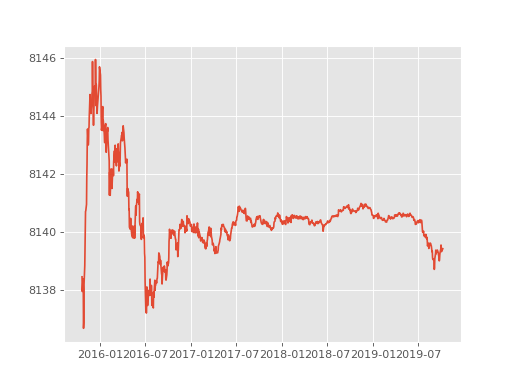

160 710
160 730
160 750
180 270
180 290
180 310
180 390
180 410
180 430
180 450
180 470
180 490
180 510
180 530
180 550
180 570
180 590
180 610
180 630
180 650
180 670
180 690
180 710
180 730
180 750
180 770
180 790
180 810
180 830
180 850
180 870
180 890
180 910
200 430
200 450
200 470
200 530
200 550
200 570
200 590
200 610
200 670
200 690
200 710
200 730
200 750
200 770
200 790
200 810
200 830
200 850
200 870
200 890
220 430
220 450
220 470
220 530
220 550
220 570
220 590
220 610
220 670
220 690
220 710
220 730
220 750
220 770
220 790
220 810
220 830
220 850
220 870
220 890
240 690
240 710
240 730
240 750
240 770
240 850
260 710
260 730
260 750
280 710
280 730
280 750
300 690
300 710
300 730
300 750
300 770
300 790
300 810
300 830
300 850
300 870
320 550
320 570
320 590
320 610
320 670
320 690
320 710
320 730
320 750
320 770
320 790
320 810
320 830
320 850
320 870
320 890
340 570
340 690
340 710
340 730
340 750
340 770
340 790
340 810
340 830
340 850
340 870
360 570
360 690
360 710


0.13860544217687074

In [369]:
%matplotlib notebook
plt.plot(np.cumsum(close['returns'].fillna(0))[-1000:])
monotonicityMeasure(np.cumsum(close['returns'].fillna(0))[-1000:])
monotonicityMeasure(np.cumsum())

In [382]:
close.loc[slice(None),'returns'][abs(close.loc[slice(None),'returns'])>1]=0

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [381]:
max(close.loc[slice(None),'returns'].dropna())

6151.476213678464

In [344]:
resultsbackup = results

In [386]:
np.mean(close['e'])

19.833913587949322

In [387]:
np.mean(close['Q'])

0.9001432945041202

<IPython.core.display.Javascript object>


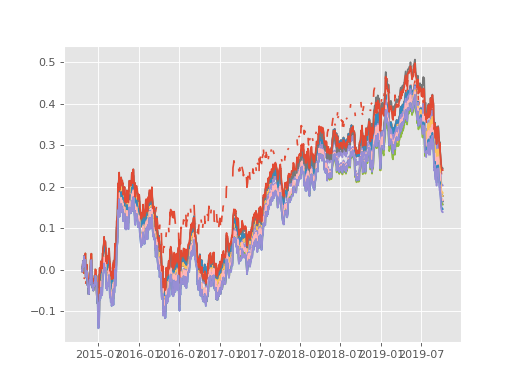

In [395]:
%matplotlib notebook

plt.plot(np.cumsum(close['returns']))

In [310]:
resultsbackup = [x for x in resultsbackup_ if x[0]>0.000001 and x[1]<0.1]

In [323]:
results

[]

In [353]:
from operator import itemgetter
sorted(results, key = itemgetter(4),reverse=True)


[[1e-09,
  0.9,
  8139.438357736922,
  7.209422814647402,
  4602.772592884957,
  4.076857921067275],
 [1e-09,
  0.8,
  7235.004267672523,
  6.408329732216584,
  4062.951416198844,
  3.5987169319741756],
 [1e-09,
  0.7,
  6330.5701687356,
  5.607236641927015,
  3535.1889883449003,
  3.1312568541584587],
 [1e-09,
  0.6,
  5426.136056629395,
  4.8061435399728945,
  2996.0782618565445,
  2.653745138934053],
 [1e-09,
  0.5,
  4521.7019237486975,
  4.005050419617976,
  2447.0386881463537,
  2.1674390506167867],
 [2e-09,
  0.9,
  4069.4848412995966,
  3.6045038452609304,
  2179.9671738099014,
  1.9308832363240904],
 [1e-09,
  0.4,
  3617.2677552365144,
  3.203957267702853,
  1906.5128874658335,
  1.6886739481539745],
 [2e-09,
  0.8,
  3617.2677516187837,
  3.20395726449848,
  1906.5128855590767,
  1.6886739464650813],
 [2e-09,
  0.7,
  3165.0506454125407,
  2.803410669098798,
  1650.7911209406586,
  1.4621710548632947],
 [1e-09,
  0.3,
  2712.833517635798,
  2.4028640545932687,
  1374.5023156

<IPython.core.display.Javascript object>


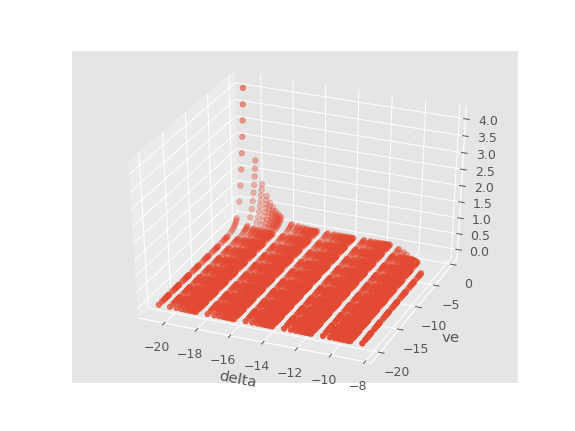

Text(0.5, 0, 've')

In [350]:
%matplotlib notebook
sharpe = [c[2] for c in resultsbackup]
delta = [c[0] for c in resultsbackup]
ve = [c[1] for c in resultsbackup]
cumRet = [c[5] for c in resultsbackup]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(delta), np.log(ve), cumRet)
ax.set_xlabel('delta')
ax.set_ylabel('ve')

In [121]:
for row in close.iterrows():
    #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
    x = np.matrix([[row[1][toTrade[0]]],[1]])
    y = np.matrix(row[1][toTrade[1]])

    ## 1 STEP AHEAD PREDICTION ##
    beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
    R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
    yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
    e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
    Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
    #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
    #                                                                             = x . R(t|t-1) + Ve


    ## UPDATE PARAMETERS ##
    K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
    beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
    P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

    #Add beta and predicted y values to arrays for storage
    betaList.append(beta)
    yhatList.append(yhat)

    #Form the hedge ratio as a float
    hedgeRatio = beta[0].tolist()[0][0]
    hedges.append(hedgeRatio)
    eList.append(e_t.tolist()[0][0])
    QList.append(Q_t.tolist()[0][0])

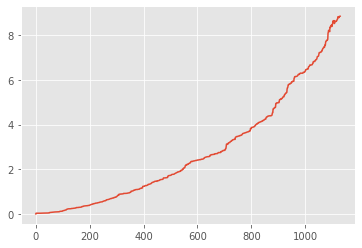

In [122]:
constants = [x.tolist()[1][0] for x in betaList]
plt.plot(constants)

In [123]:
close['e'] = eList
close["Q"] = QList

In [124]:
len(close)

1130

In [125]:
close['LongEntry'] = close['e']<-np.sqrt(close['Q'])
close['LongExit'] = close['e']>-np.sqrt(close['Q'])
close['ShortEntry'] = close['e']>np.sqrt(close['Q'])
close['ShortExit'] = close['e']<np.sqrt(close['Q'])

In [126]:
ratios = hedges
numUnitsLong = np.array([[np.nan]]*len(close))
numUnitsShort = np.array([[np.nan]]*len(close))

numUnitsLong[0] = 1
numUnitsLong[np.array(close['LongEntry'])] = 1
numUnitsLong[np.array(close['LongExit'])] = 0

numUnitsShort[0] = 1
numUnitsShort[np.array(close['ShortEntry'])] = -1
numUnitsShort[np.array(close['ShortExit'])] = 0

close['short'] = numUnitsShort
close['short'].fillna('ffill')
close['long'] =  numUnitsLong
close['long'].fillna('ffill')

close['numUnits'] = close['long'] + close['short']
# numUnitsPortfolio = (numUnitsShort + numUnitsLong)
# numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.matrix(ratios).T)
# positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))

# #we calculate pnl by first calculating the percent change of price in each asset
# pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
# pnl = pnl.sum(axis=1)

# #returnzzzz bruh
# returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
# cumulativeReturns = np.cumsum(returns, axis=0)

In [127]:
close['numUnits'+toTrade[0]] = -close['numUnits']*ratios
close['numUnits'+toTrade[1]] = close['numUnits']

In [128]:
close['positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
close['positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]

In [129]:
# close['pnl'+toTrade[0]] = 

In [130]:
close['pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))

In [139]:
close['returns'] = close['pnl']/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

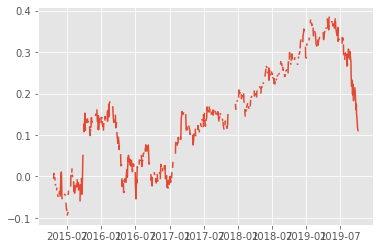

In [140]:
plt.plot(np.cumsum(close['returns']))

In [91]:
def KalmanFilter(df): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    y = np.transpose(np.matrix(df['ewc']))
    #augment x to account for constant offset
    x = np.transpose(np.matrix([df['ewa'],[1]*len(df)]))
    
    #measurement prediction
    yhat = [np.nan]*len(df)
    #measurement prediction error variance
    Q = [np.nan]*len(df)
    #measurement prediction error
    e = [np.nan]*len(df)
    #beta matrix
    beta = [[np.nan]*len(df.columns)]*len(df)
    #R is R(t|t)
    R = np.matrix[[np.nan,np.nan],[np.nan,np.nan]]
    
    #delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
    delta = 0.0001
    Vw = delta/(1-delta)*np.diag(np.ones(len(df.columns)))
    Ve = 0.001
    
    #initialise beta
    
    ratios = []
    for i in range(len(A)):
         #testcase:use ols to find hedge ratios instead
        if i > lookback:    
            ewc_Const = sm.add_constant(df['GLD'].values[i-lookback:i]) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
            model = sm.OLS(df['USO'].values[i-lookback:i],ewc_Const).fit()
            hedge_ratio = model.params[1]
            ratios.append(hedge_ratio)
        else:
            ratios.append(0)

    #for each 1 unit of USO, we hedge with the regressed values of GLD
    ratios = pd.DataFrame(-np.array(ratios))
    ratios['USO'] = pd.Series([1]*len(ratios))
    ratios.columns = ['GLD','USO']

    spread = np.array(df['USO'])+np.multiply(np.array(ratios['GLD']), np.array(df['GLD']))    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(lookback)).std())
    marketValMA = np.array(spread.rolling(math.floor(lookback)).mean())
    #calculate negative z score from moving average
    z = (spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))
    #BOLLINGER BAND COMPONENT
    entryZscore = 1
    exitZscore = 0
    
    longsEntry = z < -entryZscore    # a long position means we should buy USO
    longsExit = z >= -exitZscore     # sell our long position
    
    shortEntry = z > entryZscore     # create a short position, sell GLD
    shortExit = z <= exitZscore      # buy back our short
    
    numUnitsLong = np.array([[np.nan]]*len(z))
    numUnitsShort = np.array([[np.nan]]*len(z))
    
    numUnitsLong[0] = 1
    numUnitsLong[np.array(longsEntry)] = 1
    numUnitsLong[np.array(longsExit)] = 0
    
    numUnitsShort[0] = 1
    numUnitsShort[np.array(shortEntry)] = -1
    numUnitsShort[np.array(shortExit)] = 0
    
    #use pandas , .fillna(method='ffill') 
    for i in range(len(numUnitsLong)):
        if np.isnan(numUnitsLong[i][0]):
            numUnitsLong[i][0] = numUnitsLong[i-1] 
        if np.isnan(numUnitsShort[i][0]):
            numUnitsShort[i][0] = numUnitsShort[i-1] 

    numUnitsPortfolio = (numUnitsShort + numUnitsLong)
    numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.array(ratios))
    positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))
    
    #we calculate pnl by first calculating the percent change of price in each asset
    pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
    pnl = pnl.sum(axis=1)
    
    #returnzzzz bruh
    returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
    cumulativeReturns = np.cumsum(returns, axis=0)


    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe


plot, sharpe = KalmanFilter(close[['ewc','ewa']])
print(sharpe)
plt.plot(plot)
plt.title('EWC/EWA efts')
plt.show()

TypeError: 'type' object is not subscriptable

In [4]:
features = df.columns
features = [ 'ewc', 'ewa', 'ige']
toTrade = features

In [125]:
features = [ 'ewc', 'ewa', 'ige']
toTrade = features

In [41]:
delta = 0.0001
ve = 0.001

In [131]:
yhat = [np.matrix(0)]           #stores the measurement prediction of the linear model y (t) = x(t)*β(t) + e(t). Store for each time step.

#The variance in the measurement prediction. Store for each time step.
Q = []

#The prediction error at each time step.
e = []

#Store the beta values
beta_list = [np.matrix([[0],[0],[0]])]

#Covariance Arrays,  measuring the covariance of the error of the hidden variable, β,  estimates
#For clarity, we denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) is cov(β(t) − βhat(t|t-1))
R = np.zeros([len(features),len(features)])
P = np.zeros([len(features),len(features)])

#delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
Vw = delta/(1-delta)*np.diag(np.ones(len(features)))


#Decimal Places should be assigned globally for transparency

#Store the hedge ratios
hedges = []

# # For validation
# # DELETE FOR SPEED
# self.yhat_val = []
y = []
yhatPlusQ = []
yhatMinusQ = []
# self.Q = []

hedges = []

#The underlying time series, e.g. we use the snp500 for the ASX if we're testing aussie assets.



In [132]:
yhat = [np.matrix(0)]           #stores the measurement prediction of the linear model y (t) = x(t)*β(t) + e(t). Store for each time step.

#The variance in the measurement prediction. Store for each time step.
Q = []

#The prediction error at each time step.
e = []

#Store the beta values
beta_list = [np.matrix([[0],[0],[0]])]

#Covariance Arrays,  measuring the covariance of the error of the hidden variable, β,  estimates
#For clarity, we denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) is cov(β(t) − βhat(t|t-1))
R = np.zeros([len(features),len(features)])
P = np.zeros([len(features),len(features)])

#delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
Vw = delta/(1-delta)*np.diag(np.ones(len(features)))


#Decimal Places should be assigned globally for transparency

#Store the hedge ratios
hedges = []

# # For validation
# # DELETE FOR SPEED
# self.yhat_val = []
y = []
yhatPlusQ = []
yhatMinusQ = []
# self.Q = []

hedges = []

#The underlying time series, e.g. we use the snp500 for the ASX if we're testing aussie assets.


for row in df.iterrows():
    row = list(list(row)[1])
    y = np.matrix(row[3])
    x = np.matrix([[row[1]],[row[2]],[1]])
    
    
    beta = beta_list[-1]
    R = P + Vw
    
    yhat = np.dot(x.T, beta)
    e_t = y - yhat 
    Q_t = np.dot( np.dot(x.T, R) , x ) + ve
    
    K = np.matrix(np.dot(R, x)/Q_t)
    beta = beta + K*e_t
    P = R - np.dot(np.dot(K, x.T), R)
    e.append(e_t.tolist()[0][0])
    Q.append(Q_t.tolist()[0][0])
    beta_list.append(beta)
   
    hedges.append([beta.tolist()[0][0],beta.tolist()[1][0]])
#     beta = beta[-1]


In [82]:
e = [x.tolist()[0][0] for x in e]

In [107]:
len(df)

1500

In [123]:
toTrade

['GOLD.AX', 'OOO.AX']

In [13]:
ve_values = []
delta_values = []
for ve_ in range(1,10):
    order = round(0.1**(ve_+3), 12)
    for i in range(1,10):
        ve_values.append(round(i*order*100,12))
        delta_values.append(round(i*order,12))
for delta in delta_values:
    for ve in ve_values:
        close = df
        
        features = [ 'ewc', 'ewa', 'ige']
        toTrade = features
        yhat = [np.matrix(0)]           #stores the measurement prediction of the linear model y (t) = x(t)*β(t) + e(t). Store for each time step.

        #The variance in the measurement prediction. Store for each time step.
        Q = []

        #The prediction error at each time step.
        e = []

        #Store the beta values
        beta_list = [np.matrix([[0],[0],[0]])]

        #Covariance Arrays,  measuring the covariance of the error of the hidden variable, β,  estimates
        #For clarity, we denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) is cov(β(t) − βhat(t|t-1))
        R = np.zeros([len(features),len(features)])
        P = np.zeros([len(features),len(features)])

        #delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
        Vw = delta/(1-delta)*np.diag(np.ones(len(features)))


        #Decimal Places should be assigned globally for transparency

        #Store the hedge ratios
        hedges = []

        # # For validation
        # # DELETE FOR SPEED
        # self.yhat_val = []
        y = []
        yhatPlusQ = []
        yhatMinusQ = []
        # self.Q = []

        hedges = []

        #The underlying time series, e.g. we use the snp500 for the ASX if we're testing aussie assets.


        for row in df.iterrows():
            row = list(list(row)[1])
            y = np.matrix(row[3])
            x = np.matrix([[row[1]],[row[2]],[1]])


            beta = beta_list[-1]
            R = P + Vw

            yhat = np.dot(x.T, beta)
            e_t = y - yhat 
            Q_t = np.dot( np.dot(x.T, R) , x ) + ve

            K = np.matrix(np.dot(R, x)/Q_t)
            beta = beta + K*e_t
            P = R - np.dot(np.dot(K, x.T), R)
            e.append(e_t.tolist()[0][0])
            Q.append(Q_t.tolist()[0][0])
            beta_list.append(beta)

            hedges.append([beta.tolist()[0][0],beta.tolist()[1][0]])
        #     beta = beta[-1]

        close.loc[slice(None),'e'] = e
        close.loc[slice(None),'Q'] = Q

        # if np.mean(close['e'])>np.sqrt(np.mean(close['Q'])):
        # #                 print('means',np.mean(close['e']), np.sqrt(np.mean(close['Q'])))
        # #             if the average error is greater than the average deviation the parameters are fucked. No point going further
        #     break


        close.loc[slice(None),'LongEntry'] = close['e']<-np.sqrt(close['Q'])
        close.loc[slice(None),'LongExit'] = close['e']>-np.sqrt(close['Q'])
        close.loc[slice(None),'ShortEntry'] = close['e']>np.sqrt(close['Q'])
        close.loc[slice(None),'ShortExit'] = close['e']<np.sqrt(close['Q'])

        numUnitsLong = np.array([[np.nan]]*len(close))
        numUnitsShort = np.array([[np.nan]]*len(close))

        numUnitsLong[0] = 1
        numUnitsLong[np.array(close['LongEntry'])] = 1
        numUnitsLong[np.array(close['LongExit'])] = 0

        numUnitsShort[0] = 1
        numUnitsShort[np.array(close['ShortEntry'])] = -1
        numUnitsShort[np.array(close['ShortExit'])] = 0

        close.loc[slice(None),'short'] = numUnitsShort
        close.loc[slice(None),'short'].fillna('ffill')
        close.loc[slice(None),'long'] =  numUnitsLong
        close.loc[slice(None),'long'].fillna('ffill')

        close.loc[slice(None),'numUnits'] = close['long'] + close['short']

        close.loc[slice(None),'numUnits'+toTrade[0]] = -close['numUnits']*[x[0] for x in hedges]
        close.loc[slice(None),'numUnits'+toTrade[1]] = -close['numUnits']*[x[1] for x in hedges]

        close.loc[slice(None),'numUnits'+toTrade[2]] = close['numUnits']

        close.loc[slice(None),'positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
        close.loc[slice(None),'positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]
        close.loc[slice(None),'positions'+toTrade[2]] = close['numUnits'+toTrade[2]]*close[toTrade[2]]

        close.loc[slice(None),'pnl'] =sum([ close[asset].pct_change()*close['positions'+asset].shift(1) for asset in toTrade])



        close.loc[slice(None),'returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)
        print(delta, ve, np.cumsum(close['returns']).dropna()[-1])

0.0001 0.01 0.3703286759534037
0.0001 0.02 0.3526383908209795
0.0001 0.03 0.3347650049622793
0.0001 0.04 0.3774463641650166
0.0001 0.05 0.31115674445549724
0.0001 0.06 0.3422164535362341
0.0001 0.07 0.3780171170099701
0.0001 0.08 0.3539008952891715
0.0001 0.09 0.3368762811234707
0.0001 0.001 0.4485017376554637
0.0001 0.002 0.3938169270916172
0.0001 0.003 0.39090606092391844
0.0001 0.004 0.3852141518553442
0.0001 0.005 0.3801833773003047
0.0001 0.006 0.36835787732884506
0.0001 0.007 0.3706455675397546
0.0001 0.008 0.35806355842924564
0.0001 0.009 0.36036858572513214
0.0001 0.0001 0.4617348340830537
0.0001 0.0002 0.46196967912508236
0.0001 0.0003 0.4516521567387637
0.0001 0.0004 0.4518740274575965
0.0001 0.0005 0.4427339525020545
0.0001 0.0006 0.4418723900086626
0.0001 0.0007 0.4420838640846712
0.0001 0.0008 0.4481348354498174
0.0001 0.0009 0.44831911628285337
0.0001 1e-05 0.46152148585366476
0.0001 2e-05 0.4615452852762555
0.0001 3e-05 0.4615690610772346
0.0001 4e-05 0.4615928133021049


0.0007 0.008 0.08590792107475982
0.0007 0.009 0.08610865061441424
0.0007 0.0001 0.0741139547950752
0.0007 0.0002 0.07413590565218744
0.0007 0.0003 0.07415783163181335
0.0007 0.0004 0.07417973278658489
0.0007 0.0005 0.07420160916896726
0.0007 0.0006 0.07422346083126098
0.0007 0.0007 0.07424528782560227
0.0007 0.0008 0.07426709020396291
0.0007 0.0009 0.07428886801815242
0.0007 1e-05 0.07409417770978871
0.0007 2e-05 0.07409637616211988
0.0007 3e-05 0.0740985743647252
0.0007 4e-05 0.0741007723176572
0.0007 5e-05 0.07410297002096848
0.0007 6e-05 0.07410516747471287
0.0007 7e-05 0.07410736467894279
0.0007 8e-05 0.07410956163371087
0.0007 9e-05 0.07411175833907066
0.0007 1e-06 0.07409219888913061
0.0007 2e-06 0.07409241876808505
0.0007 3e-06 0.07409263864454127
0.0007 4e-06 0.07409285851849903
0.0007 5e-06 0.07409307838995877
0.0007 6e-06 0.07409329825892101
0.0007 7e-06 0.07409351812538466
0.0007 8e-06 0.07409373798935051
0.0007 9e-06 0.07409395785081847
0.0007 1e-07 0.07409200099593556
0.00

4e-05 8e-06 0.5406034320589971
4e-05 9e-06 0.5406089840817327
4e-05 1e-07 0.5439499689946217
4e-05 2e-07 0.5439505282738932
4e-05 3e-07 0.5439510875412825
4e-05 4e-07 0.5439516467967866
4e-05 5e-07 0.5439522060404066
4e-05 6e-07 0.5439527652721425
4e-05 7e-07 0.5439533244919942
4e-05 8e-07 0.5439538836999648
4e-05 9e-07 0.543954442896053
4e-05 1e-08 0.5439494656331111
4e-05 2e-08 0.543949521562643
4e-05 3e-08 0.5439495774920557
4e-05 4e-08 0.5439496334213508
4e-05 5e-08 0.5439496893505268
4e-05 6e-08 0.5439497452795815
4e-05 7e-08 0.54394980120852
4e-05 8e-08 0.5439498571373395
4e-05 9e-08 0.5439499130660381
4e-05 1e-09 0.5439494152964309
4e-05 2e-09 0.5439494208893999
4e-05 3e-09 0.5439494264823688
4e-05 4e-09 0.543949432075335
4e-05 5e-09 0.5439494376683011
4e-05 6e-09 0.5439494432612648
4e-05 7e-09 0.5439494488542281
4e-05 8e-09 0.5439494544471903
4e-05 9e-09 0.5439494600401513
4e-05 1e-10 0.5439494102627579
4e-05 2e-10 0.5439494108220554
4e-05 3e-10 0.5439494113813519
4e-05 4e-10 0

2e-06 0.02 0.657910384108253
2e-06 0.03 0.6344008321781506
2e-06 0.04 0.5724959156477434
2e-06 0.05 0.564356467423939
2e-06 0.06 0.5682236399553794
2e-06 0.07 0.587164722208699
2e-06 0.08 0.6453715360141148
2e-06 0.09 0.5917958947575318
2e-06 0.001 0.6373615660994574
2e-06 0.002 0.6563435182383927
2e-06 0.003 0.6689571075236299
2e-06 0.004 0.6935264121412271
2e-06 0.005 0.6774480842150119
2e-06 0.006 0.6617261564321377
2e-06 0.007 0.6973995802191826
2e-06 0.008 0.6768348069879628
2e-06 0.009 0.6619631693732129
2e-06 0.0001 0.5180480669267998
2e-06 0.0002 0.529339204647151
2e-06 0.0003 0.5170655166971706
2e-06 0.0004 0.546610112550934
2e-06 0.0005 0.5432093539279143
2e-06 0.0006 0.5781770307168496
2e-06 0.0007 0.6117902478649013
2e-06 0.0008 0.5980908807102977
2e-06 0.0009 0.6290512464914775
2e-06 1e-05 0.6037033589943723
2e-06 2e-05 0.5638743766866505
2e-06 3e-05 0.557659231202407
2e-06 4e-05 0.5670354585380537
2e-06 5e-05 0.5283719399797483
2e-06 6e-05 0.5316721112055786
2e-06 7e-05 0

8e-06 1e-07 0.586808603953691
8e-06 2e-07 0.586123527543792
8e-06 3e-07 0.5861259614745257
8e-06 4e-07 0.5861283952538106
8e-06 5e-07 0.5861308288816477
8e-06 6e-07 0.5861332623580477
8e-06 7e-07 0.586135695683012
8e-06 8e-07 0.5861381288565457
8e-06 9e-07 0.5861405618786549
8e-06 1e-08 0.5868064085495309
8e-06 2e-08 0.5868066524894152
8e-06 3e-08 0.5868068964277772
8e-06 4e-08 0.5868071403646173
8e-06 5e-08 0.5868073842999345
8e-06 6e-08 0.5868076282337297
8e-06 7e-08 0.5868078721660024
8e-06 8e-08 0.586808116096754
8e-06 9e-08 0.5868083600259842
8e-06 1e-09 0.5868061890023367
8e-06 2e-09 0.5868062133965288
8e-06 3e-09 0.5868062377907084
8e-06 4e-09 0.5868062621848703
8e-06 5e-09 0.5868062865790183
8e-06 6e-09 0.5868063109731502
8e-06 7e-09 0.5868063353672677
8e-06 8e-09 0.5868063597613721
8e-06 9e-09 0.58680638415546
8e-06 1e-10 0.5868061670475474
8e-06 2e-10 0.5868061694869687
8e-06 3e-10 0.5868061719263913
8e-06 4e-10 0.58680617436581
8e-06 5e-10 0.5868061768052315
8e-06 6e-10 0.58

6e-07 0.09 1.0091340218218436
6e-07 0.001 0.7933230289898239
6e-07 0.002 0.6810565231085987
6e-07 0.003 0.6807691917500829
6e-07 0.004 0.635036511502072
6e-07 0.005 0.6293302279325462
6e-07 0.006 0.5715031353595599
6e-07 0.007 0.6064922550213078
6e-07 0.008 0.6197257712029978
6e-07 0.009 0.5744709314725912
6e-07 0.0001 0.576055720733637
6e-07 0.0002 0.5929689726660939
6e-07 0.0003 0.6313972693973257
6e-07 0.0004 0.6910219617540793
6e-07 0.0005 0.7104531594366004
6e-07 0.0006 0.7775124321073105
6e-07 0.0007 0.8278167177364337
6e-07 0.0008 0.8053783735672453
6e-07 0.0009 0.7674258086606557
6e-07 1e-05 0.5388697139606181
6e-07 2e-05 0.5583330084576886
6e-07 3e-05 0.5364357168592199
6e-07 4e-05 0.5620220881019179
6e-07 5e-05 0.5565403812613559
6e-07 6e-05 0.5533810486156928
6e-07 7e-05 0.5874480088761982
6e-07 8e-05 0.595199463101114
6e-07 9e-05 0.594342798640281
6e-07 1e-06 0.583904878475601
6e-07 2e-06 0.5841241039467528
6e-07 3e-06 0.578015482786964
6e-07 4e-06 0.5653855139930283
6e-07 

9e-07 4e-05 0.5600222755681182
9e-07 5e-05 0.5427497418962824
9e-07 6e-05 0.5556057099271674
9e-07 7e-05 0.5659863544197322
9e-07 8e-05 0.5884693825474552
9e-07 9e-05 0.5665807638543057
9e-07 1e-06 0.574478676850485
9e-07 2e-06 0.5746312148939452
9e-07 3e-06 0.5704840265035388
9e-07 4e-06 0.5706355621024646
9e-07 5e-06 0.5712146805725505
9e-07 6e-06 0.5582333051177079
9e-07 7e-06 0.5710514531129635
9e-07 8e-06 0.5674023399355991
9e-07 9e-06 0.5657120276180695
9e-07 1e-07 0.5743412953167123
9e-07 2e-07 0.5743565638128155
9e-07 3e-07 0.5743718314057015
9e-07 4e-07 0.5743870980663187
9e-07 5e-07 0.5744023637658198
9e-07 6e-07 0.574417628475554
9e-07 7e-07 0.5744328921670595
9e-07 8e-07 0.5744481548120677
9e-07 9e-07 0.5744634163825039
9e-07 1e-08 0.574327552922136
9e-07 2e-08 0.5743290798891605
9e-07 3e-08 0.5743306068476802
9e-07 4e-08 0.5743321337976646
9e-07 5e-08 0.5743336607390871
9e-07 6e-08 0.5743351876719142
9e-07 7e-08 0.5743367145961219
9e-07 8e-08 0.5743382415116768
9e-07 9e-08

6e-08 3e-10 0.5569498919150785
6e-08 4e-10 0.5569501735414393
6e-08 5e-10 0.5569504551662106
6e-08 6e-10 0.5569507367893974
6e-08 7e-10 0.5569510184109964
6e-08 8e-10 0.55695130003101
6e-08 9e-10 0.5569515816494388
7e-08 0.01 1.0958277272185015
7e-08 0.02 1.9494339221450312
7e-08 0.03 2.6513262235897397
7e-08 0.04 3.4442578149033554
7e-08 0.05 4.050759804888606
7e-08 0.06 4.815704472785289
7e-08 0.07 5.503205473213179
7e-08 0.08 6.256448802370246
7e-08 0.09 7.0415218359432385
7e-08 0.001 0.5941031121299938
7e-08 0.002 0.5695980714698554
7e-08 0.003 0.603429963009809
7e-08 0.004 0.6520639474887732
7e-08 0.005 0.7093555504683624
7e-08 0.006 0.8397960553400567
7e-08 0.007 0.9191977308435044
7e-08 0.008 0.96351714333094
7e-08 0.009 0.9656250768884106
7e-08 0.0001 0.854388629993792
7e-08 0.0002 0.8493641281081536
7e-08 0.0003 0.7208931639813926
7e-08 0.0004 0.6510425139726713
7e-08 0.0005 0.6241078187942501
7e-08 0.0006 0.6081452688274185
7e-08 0.0007 0.6307516965405066
7e-08 0.0008 0.63351

4e-09 3e-06 0.7216144654497183
4e-09 4e-06 0.7767423171758165
4e-09 5e-06 0.8296276095480211
4e-09 6e-06 0.8280166603280421
4e-09 7e-06 0.7988248526906335
4e-09 8e-06 0.8132460825614815
4e-09 9e-06 0.8668671714734676
4e-09 1e-07 0.4643367863000366
4e-09 2e-07 0.5222828879465239
4e-09 3e-07 0.5548979631162975
4e-09 4e-07 0.5951344578142624
4e-09 5e-07 0.6060609023812397
4e-09 6e-07 0.637128309744946
4e-09 7e-07 0.6412482958336492
4e-09 8e-07 0.5883836269197336
4e-09 9e-07 0.5786620668143762
4e-09 1e-08 0.5441197882376486
4e-09 2e-08 0.5446223925538702
4e-09 3e-08 0.546069973489824
4e-09 4e-08 0.5464962469598711
4e-09 5e-08 0.5373178015165954
4e-09 6e-08 0.5297597099541066
4e-09 7e-08 0.5304524089721729
4e-09 8e-08 0.5216219911548841
4e-09 9e-08 0.489781374923535
4e-09 1e-09 0.5379562543900538
4e-09 2e-09 0.5380006907065358
4e-09 3e-09 0.5380450938456792
4e-09 4e-09 0.5380894636456836
4e-09 5e-09 0.5422350276654028
4e-09 6e-09 0.5422797498320668
4e-09 7e-09 0.54232443140844
4e-09 8e-09 0

2e-10 0.04 1036.1326462801226
2e-10 0.05 1295.139742072938
2e-10 0.06 1554.1462666960115
2e-10 0.07 1813.1524417338144
2e-10 0.08 2072.158387450244
2e-10 0.09 2331.1641747017734
2e-10 0.001 26.31433118372227
2e-10 0.002 52.10590818677641
2e-10 0.003 78.02773571170388
2e-10 0.004 103.79464182233188
2e-10 0.005 129.6379521249699
2e-10 0.006 155.4551957822003
2e-10 0.007 181.35066032596956
2e-10 0.008 207.28679454657023
2e-10 0.009 233.21778547275972
2e-10 0.0001 2.8474531954948725
2e-10 0.0002 5.4258549269774
2e-10 0.0003 8.098543876104465
2e-10 0.0004 10.797423992797016
2e-10 0.0005 13.268302649152826
2e-10 0.0006 15.953747507337145
2e-10 0.0007 18.6438550470126
2e-10 0.0008 21.314116697576
2e-10 0.0009 23.79625789650993
2e-10 1e-05 0.6085247789070973
2e-10 2e-05 0.8373077953247509
2e-10 3e-05 1.2012967647169221
2e-10 4e-05 1.498021763779828
2e-10 5e-05 1.8186688136906344
2e-10 6e-05 1.9711194308942406
2e-10 7e-05 2.229181058011815
2e-10 8e-05 2.4157125331044886
2e-10 9e-05 2.6669079962

8e-10 6e-07 0.7015072056298882
8e-10 7e-07 0.7492508651570166
8e-10 8e-07 0.7682531173613043
8e-10 9e-07 0.8616771345291995
8e-10 1e-08 0.5304112568844391
8e-10 2e-08 0.47636439723757784
8e-10 3e-08 0.48433785356444736
8e-10 4e-08 0.5351199165397343
8e-10 5e-08 0.5312311936989152
8e-10 6e-08 0.5564475096461373
8e-10 7e-08 0.5753624510245794
8e-10 8e-08 0.6020682489381056
8e-10 9e-08 0.6016332567219417
8e-10 1e-09 0.5381337999487666
8e-10 2e-09 0.5424582318310527
8e-10 3e-09 0.5426804138918658
8e-10 4e-09 0.5517599748454506
8e-10 5e-09 0.53932320043559
8e-10 6e-09 0.535354601306662
8e-10 7e-09 0.5347207078255006
8e-10 8e-09 0.5377403983474078
8e-10 9e-09 0.5381695055711434
8e-10 1e-10 0.537934023841864
8e-10 2e-10 0.5379562543901949
8e-10 3e-10 0.5379784766854331
8e-10 4e-10 0.5380006907068189
8e-10 5e-10 0.5380228964338206
8e-10 6e-10 0.5380450938461054
8e-10 7e-10 0.5380672829235541
8e-10 8e-10 0.5380894636462508
8e-10 9e-10 0.5381116359944897
9e-10 0.01 57.93969533057088
9e-10 0.02 1

6e-11 0.009 777.1245220168755
6e-11 0.0001 8.974657098931077
6e-11 0.0002 17.725301632923188
6e-11 0.0003 26.33176753450011
6e-11 0.0004 34.92078350633317
6e-11 0.0005 43.495546454621014
6e-11 0.0006 52.09630134055669
6e-11 0.0007 60.75961244852119
6e-11 0.0008 69.47710452173538
6e-11 0.0009 78.01012793924819
6e-11 1e-05 1.305384408979033
6e-11 2e-05 2.1828436532963247
6e-11 3e-05 2.8379521293677836
6e-11 4e-05 3.7201056550140823
6e-11 5e-05 4.5081421264713475
6e-11 6e-05 5.42719004605549
6e-11 7e-05 6.331833950302688
6e-11 8e-05 7.210225081929696
6e-11 9e-05 8.082293711503848
6e-11 1e-06 0.5941531444794865
6e-11 2e-06 0.6056503451420492
6e-11 3e-06 0.609312213225062
6e-11 4e-06 0.6820611116189723
6e-11 5e-06 0.7104267111504974
6e-11 6e-06 0.8512667464042223
6e-11 7e-06 1.0006584169013983
6e-11 8e-06 1.1014714953635067
6e-11 9e-06 1.2237244723064034
6e-11 1e-07 0.8227460219827372
6e-11 2e-07 0.8600356614024456
6e-11 3e-07 0.6636674811447657
6e-11 4e-07 0.6198012573261035
6e-11 5e-07 0.

3e-12 3e-09 0.8148312356882149
3e-12 4e-09 0.7963916890238828
3e-12 5e-09 0.8227460219833421
3e-12 6e-09 0.801609202370358
3e-12 7e-09 0.881267962409768
3e-12 8e-09 0.8748892141082246
3e-12 9e-09 0.9096027999446815
3e-12 1e-10 0.47080776164805527
3e-12 2e-10 0.5386430199648411
3e-12 3e-10 0.604588557409939
3e-12 4e-10 0.6213138925935621
3e-12 5e-10 0.6548273439023555
3e-12 6e-10 0.5716882704076219
3e-12 7e-10 0.5843296680672434
3e-12 8e-10 0.6020211848515964
3e-12 9e-10 0.5868358814598857
4e-12 0.01 12950.380770782014
4e-12 0.02 25900.640212816284
4e-12 0.03 38850.89932496812
4e-12 0.04 51801.1583539233
4e-12 0.05 64751.4173494836
4e-12 0.06 77701.67632831409
4e-12 0.07 90651.93529757316
4e-12 0.08 103602.19426084515
4e-12 0.09 116552.45322012251
4e-12 0.001 1295.1397423267636
4e-12 0.002 2590.169848427929
4e-12 0.003 3885.1972675955403
4e-12 0.004 5180.223948196286
4e-12 0.005 6475.250322061795
4e-12 0.006 7770.276539368188
4e-12 0.007 9065.302666032207
4e-12 0.008 10360.32873552701
4

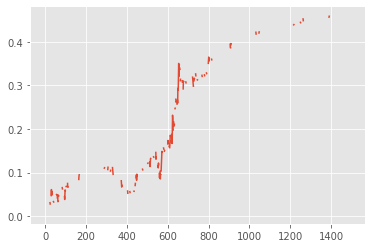

In [135]:
plt.plot(np.cumsum(close['returns']))

In [19]:
row[1][1]

26.31

In [136]:
close

,Date,ewc,ewa,ige,e,Q,LongEntry,LongExit,ShortEntry,ShortExit,...,numUnitsGOLD.AX,numUnitsOOO.AX,numUnitsewc,numUnitsewa,numUnitsige,positionsewc,positionsewa,positionsige,pnl,returns
0,0,22.95,16.10,31.76,31.760000,0.079699,False,True,True,False,...,0.914646,0.641647,0.914646,0.641647,-1.0,20.991128,10.330519,-31.76,NaN,NaN
1,1,22.78,15.98,31.32,0.190986,0.079510,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.207513,0.004943
2,2,22.94,16.10,31.81,0.267708,0.080655,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
3,3,23.05,16.31,32.26,0.214551,0.081846,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
4,4,23.32,16.29,32.97,0.473557,0.083041,False,True,True,False,...,0.947657,0.664437,0.947657,0.664437,-1.0,22.099361,10.823686,-32.97,0.000000,NaN
5,5,23.12,16.32,32.54,-0.254699,0.082183,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.260402,0.005892
6,6,23.01,16.27,32.42,0.013316,0.081505,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
7,7,23.33,16.56,32.82,-0.092156,0.083980,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
8,8,23.23,16.63,32.69,-0.083292,0.083723,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
9,9,23.54,16.96,33.16,-0.037582,0.086312,False,True,False,True,...,-0.000000,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,0.00,0.000000,NaN
